In [5]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fake-news-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4641663%2F7902961%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240701%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240701T082640Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3dd114d4778bbbf69b3029a96d24594af240453476b1497268c22fe5f8ac31f70150ee2d27c0d08fda0e6935cd65f68ac34410dee6d8b0dc33c1b91e0cc0028db6290047df774e09338359526564fcb66c1ac10e352352e0c6f08a071fb781b48b3263d75cc71941512f3b477a2f62ab447b8263de0504a7f30f185ea8c65ee1e2d25157a9d80d3b77c3c59cc78aeecccfd8f8b1743b093ba6ca4529f4780e7c90d1685e647945ff9c8ce093df43d63062362b0812b8e29990a6826328e6624236c1d622a6a87b4b6834a936d1653b10a87390501580a450380b04e2f66ac65fa40bf62306117b3eb7b7794f797b0101db36fc8e24d94c82dd066051f670e62d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 9823999 bytes downloaded
Downloaded and uncompressed: fake-news-detection
Data source import complete.


# Data Retrival

In [6]:
#locating files

!tree /kaggle/input

/bin/bash: line 1: tree: command not found


In [7]:
import pandas as pd

rawdf = pd.read_csv('/kaggle/input/fake-news-detection/fake_and_real_news.csv')
rawdf.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


# Preprocessing

In [8]:
!pip install nltk

In [9]:
import nltk

nltk.download('punkt') # for tokenization
nltk.download('stopwords') # for stopword removal
nltk.download('averaged_perceptron_tagger') # PoS tagging
nltk.download('wordnet') # for lemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [10]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
# function to remove punctuations.
def remove_punc(text):
    nonP_text = ''.join(char for char in text if char not in string.punctuation)
    return nonP_text


# function to tokenize
import re
def tokenize(text):
    tokens = re.split('\W+', text) # splitting at all capital, small alphabets and integers 0-9
    return tokens


# function to remove stopwords
import nltk
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(token):
    text = [word for word in token if word not in stopwords]# removes stopwords
    return text


# function for stemming
ps = nltk.PorterStemmer()
def stemming(t_text):
    text = [ps.stem(word) for word in t_text]
    return text


# function for lemmatization
wn = nltk.WordNetLemmatizer()
def lemmatizer(t_text):
    text = [wn.lemmatize(word) for word in t_text]
    return text

In [12]:
def preprocess(text):
    text = remove_punc(text)
    text = tokenize(text)
    text = remove_stopwords(text)
    text = stemming(text)
    text = lemmatizer(text)
    return text

In [13]:
# for testing

preprocessed_df = rawdf.copy()
preprocessed_df['text_processed'] = preprocessed_df['Text'].head().apply(preprocess)
preprocessed_df.head()

,Text,label,text_processed
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,"[, top, trump, surrog, brutal, stab, him, in, ..."
1,U.S. conservative leader optimistic of common ...,Real,"[u, conserv, leader, optimist, common, ground,..."
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,"[trump, propos, u, tax, overhaul, stir, concer..."
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,"[, court, forc, ohio, to, allow, million, of, ..."
4,Democrats say Trump agrees to work on immigrat...,Real,"[democrat, say, trump, agre, work, immigr, bil..."


In [14]:
# Function to calculate length of message excluding space
rawdf['text_len'] = rawdf['Text'].apply(lambda x: len(x) - x.count(" "))

# Function to count punctuations%
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

rawdf['punct%'] = rawdf['Text'].apply(lambda x: count_punct(x))


rawdf.head()

,Text,label,text_len,punct%
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,1265,2.8
1,U.S. conservative leader optimistic of common ...,Real,641,2.7
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,5162,3.1
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,1901,2.8
4,Democrats say Trump agrees to work on immigrat...,Real,3154,2.2


# Vectorization

In [22]:
X_df = rawdf[['Text','text_len','punct%']]
y_df = rawdf['label'].apply(lambda x: 1 if x=='Real' else 0)

In [16]:
X_df.head()

,Text,text_len,punct%
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,1265,2.8
1,U.S. conservative leader optimistic of common ...,641,2.7
2,"Trump proposes U.S. tax overhaul, stirs concer...",5162,3.1
3,Court Forces Ohio To Allow Millions Of Illega...,1901,2.8
4,Democrats say Trump agrees to work on immigrat...,3154,2.2


In [23]:
y_df

0       0
1       1
2       1
3       0
4       1
       ..
9895    0
9896    1
9897    1
9898    0
9899    0
Name: label, Length: 9900, dtype: int64

In [18]:
# TF-IDF vectorization

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer=preprocess)
X_tfidf = tfidf_vect.fit_transform(X_df['Text'])

In [19]:
X_tfidf.shape

(9900, 75955)

In [20]:
tfidf_vect.get_feature_names_out()

array(['', '0', '000', ..., 'zzzzzzzzzzzzz', 'émigré', 'ツ'], dtype=object)

In [21]:
X_tfidf_df = pd.concat([X_df[['text_len','punct%']].reset_index(drop=True), pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vect.get_feature_names_out())], axis=1)
X_tfidf_df.head()

,text_len,punct%,,0,000,0000,000063sz,00007,0005,0009,...,zyklon,zypri,zyri,zz,zzbluecomet,zztain,zzzzaaaacccchhh,zzzzzzzzzzzzz,émigré,ツ
0,1265,2.8,0.017458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,641,2.7,0.026306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5162,3.1,0.005481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1901,2.8,0.010460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3154,2.2,0.009337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf,y_df,test_size=0.2,random_state=42)

X_train.shape, y_train.shape

((7920, 75955), (7920,))

In [24]:
! pip install yellowbrick

In [33]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
from sklearn.metrics import confusion_matrix, classification_report
from yellowbrick.classifier import ClassificationReport
import matplotlib.pyplot as plt
import seaborn as sns

Precision: 0.998 / Recall: 0.994 / F-score: 0.996 / Accuracy: 99.596%


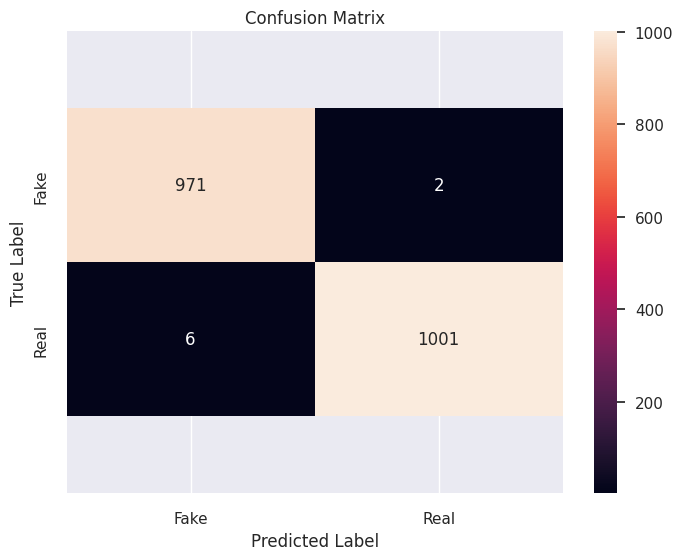

In [50]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

rf_model = rf.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

precision, recall, fscore, train_support = score(y_test, y_pred, average='binary')
print('Precision: {} / Recall: {} / F-score: {} / Accuracy: {}%'.format(
    round(precision, 3),
    round(recall, 3),
    round(fscore, 3),
    round(acs(y_test, y_pred)*100, 3)
))

sns.set(rc={'figure.figsize':(8,6)})
cm = confusion_matrix(y_test, y_pred)
class_label = ['Fake', 'Real']
df_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
ax = sns.heatmap(df_cm, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [55]:
y_pred_label = pd.DataFrame(y_pred,columns = ['Label'])
y_pred_label = y_pred_label['Label'].apply(lambda x: 'Real' if x == 1 else 'Fake')
y_pred_label.head(), y_pred_label.value_counts()

(0    Fake
 1    Real
 2    Real
 3    Real
 4    Fake
 Name: Label, dtype: object,
 Label
 Real    1003
 Fake     977
 Name: count, dtype: int64)